Approach 1: Final Test Set Evaluation

Loads full SavedModels and evaluates on HELD-OUT test set.

In [15]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_curve, auc
)
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# ==================== PATHS ====================
MODELS_DIR = '../models/models_approach1'
RESULTS_DIR = '../results/results_approach1'
SAVED_MODELS_DIR = os.path.join(MODELS_DIR, 'saved_models')
TEST_RAW_DIR = '../data/split_processed/test'  # Where raw .npy files are organized by category
INVENTORY_PATH = os.path.join(RESULTS_DIR, 'full_model_inventory.csv')
YAMNET_URL = 'https://tfhub.dev/google/yamnet/1'

os.makedirs(RESULTS_DIR, exist_ok=True)

In [16]:
# ==================== CUSTOM LAYERS (REQUIRED FOR LOADING) ====================

@tf.keras.utils.register_keras_serializable()
class YamnetEmbedding(tf.keras.layers.Layer):
    def __init__(self, yamnet_model, **kwargs):
        super().__init__(**kwargs)
        self.yamnet_model = yamnet_model

    def call(self, inputs):
        # inputs shape: (batch, 15360)
        def map_fn(wave):
            scores, embeddings, _ = self.yamnet_model(wave)
            return tf.reduce_mean(embeddings, axis=0)
        return tf.map_fn(map_fn, inputs, dtype=tf.float32)

@tf.keras.utils.register_keras_serializable()
class ScalerLayer(tf.keras.layers.Layer):
    def __init__(self, mean=None, scale=None, **kwargs):
        super(ScalerLayer, self).__init__(**kwargs)
        # If loading from config, these might be None initially, but loaded from weights
        if mean is not None:
            self.mean_val = mean
            self.mean_weight = tf.Variable(initial_value=mean, trainable=False, dtype=tf.float32, name="scaler_mean")
        if scale is not None:
            self.scale_val = scale
            self.scale_weight = tf.Variable(initial_value=scale, trainable=False, dtype=tf.float32, name="scaler_scale")

    def build(self, input_shape):
        # When loading, weights are restored automatically if they exist
        if not hasattr(self, 'mean_weight'):
             # This handles the case where the layer is initialized without args during loading
             self.mean_weight = self.add_weight(name="scaler_mean", trainable=False, shape=(1024,))
             self.scale_weight = self.add_weight(name="scaler_scale", trainable=False, shape=(1024,))
        super(ScalerLayer, self).build(input_shape)

    def call(self, inputs):
        return (inputs - self.mean_weight) / self.scale_weight

    def get_config(self):
        config = super(ScalerLayer, self).get_config()
        return config

@tf.keras.utils.register_keras_serializable()
class TemperatureSoftmax(tf.keras.layers.Layer):
    def __init__(self, temperature=1.0, **kwargs):
        super(TemperatureSoftmax, self).__init__(**kwargs)
        self.temperature = float(temperature)

    def call(self, inputs):
        return tf.nn.softmax(inputs / self.temperature)

    def get_config(self):
        config = super(TemperatureSoftmax, self).get_config()
        config.update({"temperature": self.temperature})
        return config

In [17]:
# ==================== LOAD TEST DATA ====================
# Load raw .npy files from category folders
print("Loading raw .npy files from category folders...")

# Map folder names to class names (adjusted to match your classes)
category_mapping = {
    'alarm_clock': 'Alarm_Clock',
    'car_horn': 'Car_Horn',
    'glass_breaking': 'Glass_Breaking',
    'gunshot': 'Gunshot',
    'siren': 'Siren',
    'Background': 'Background'
}

raw_audio_list = []
labels_list = []
target_length = 15360  # 0.96s @ 16kHz

for folder_name, class_name in category_mapping.items():
    folder_path = os.path.join(TEST_RAW_DIR, folder_name)
    
    if not os.path.exists(folder_path):
        print(f"  Warning: Folder not found: {folder_path}")
        continue
    
    npy_files = sorted(glob(os.path.join(folder_path, '*.npy')))
    print(f"  Loading {len(npy_files)} files from {folder_name}...")
    
    for npy_file in npy_files:
        try:
            audio = np.load(npy_file)
            
            # Ensure 1D
            if audio.ndim > 1:
                audio = audio.flatten()
            
            # Check length
            if len(audio) != target_length:
                print(f"    Skipping {os.path.basename(npy_file)}: wrong length {len(audio)}")
                continue
            
            raw_audio_list.append(audio)
            labels_list.append(class_name)
            
        except Exception as e:
            print(f"    Error loading {os.path.basename(npy_file)}: {e}")

X_test_raw = np.array(raw_audio_list, dtype=np.float32)
y_test = np.array(labels_list)

print(f"\nTotal samples loaded: {len(X_test_raw):,}")
print(f"Audio shape: {X_test_raw.shape}")

Loading raw .npy files from category folders...
  Loading 246 files from alarm_clock...
  Loading 308 files from car_horn...
  Loading 280 files from glass_breaking...
  Loading 314 files from gunshot...
  Loading 312 files from siren...
  Loading 280 files from Background...

Total samples loaded: 1,740
Audio shape: (1740, 15360)


In [18]:
# ==================== LOAD LABEL ENCODER ====================
label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
classes = label_encoder.classes_
print(f"\nClasses ({len(classes)}): {', '.join(classes)}")

# Encode labels
y_test_encoded = label_encoder.transform(y_test)

# Display class distribution
print(f"\n{'Category':<20} {'Count':<10} {'Percentage':<10}")
print("-"*50)
for idx, cls in enumerate(classes):
    count = np.sum(y_test_encoded == idx)
    percentage = count / len(y_test_encoded) * 100
    print(f"{cls:<20} {count:<10} {percentage:>6.2f}%")
print("-"*50)


Classes (6): Alarm_Clock, Background, Car_Horn, Glass_Breaking, Gunshot, Siren

Category             Count      Percentage
--------------------------------------------------
Alarm_Clock          246         14.14%
Background           280         16.09%
Car_Horn             308         17.70%
Glass_Breaking       280         16.09%
Gunshot              314         18.05%
Siren                312         17.93%
--------------------------------------------------


In [19]:
# ==================== LOAD FULL MODELS ====================
print("\nLOADING SAVED MODELS")

inventory_df = pd.read_csv(INVENTORY_PATH)
model_paths = {}

for _, row in inventory_df.iterrows():
    model_name = row['Model']
    path = row['Path']
    if os.path.exists(path):
        model_paths[model_name] = path
        print(f"  Found: {model_name}")
    else:
        print(f"  Missing: {model_name} at {path}")

print(f"\nTotal models found: {len(model_paths)}")


LOADING SAVED MODELS
  Found: Custom_Keras_NN
  Found: Random_Forest
  Found: XGBoost
  Found: SVM
  Found: Logistic_Regression

Total models found: 5


In [20]:
# ==================== INFERENCE FUNCTION ====================
def run_inference(model, audio_batch):
    """Run inference on batch of 0.96s audio clips"""
    start = time.time()
    # Batch prediction
    probs = model.predict(audio_batch, verbose=0, batch_size=32)
    latency_ms = (time.time() - start) * 1000 / len(audio_batch)
    return probs, latency_ms

# ==================== EVALUATE ALL MODELS ====================
print("\nRUNNING INFERENCE ON TEST SET")

results = []
all_predictions = {}
all_probabilities = {}

# We collect custom objects here to pass to load_model
custom_objs = {
    'YamnetEmbedding': YamnetEmbedding,
    'ScalerLayer': ScalerLayer,
    'TemperatureSoftmax': TemperatureSoftmax
}

for model_name, model_path in model_paths.items():
    print(f"\nEvaluating: {model_name}")
    
    # Load model with ALL custom layers
    try:
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=custom_objs
        )
        print(f"  Model loaded successfully")
    except Exception as e:
        print(f"  Failed to load: {e}")
        continue
    
    # Run inference
    probs, latency_ms = run_inference(model, X_test_raw)
    y_pred = np.argmax(probs, axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_test_encoded, y_pred)
    f1_macro = f1_score(y_test_encoded, y_pred, average='macro')
    f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='macro')
    recall = recall_score(y_test_encoded, y_pred, average='macro')
    
    # Get model size
    size_mb = inventory_df[inventory_df['Model'] == model_name]['Size_MB'].values[0]
    
    results.append({
        'Model': model_name,
        'Accuracy': round(acc, 4),
        'F1_Macro': round(f1_macro, 4),
        'F1_Weighted': round(f1_weighted, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'Latency_ms_per_sample': round(latency_ms, 2),
        'Size_MB': size_mb
    })
    
    all_predictions[model_name] = y_pred
    all_probabilities[model_name] = probs
    
    print(f"  Accuracy: {acc:.4f} | F1-Macro: {f1_macro:.4f} | Latency: {latency_ms:.2f} ms/sample")


RUNNING INFERENCE ON TEST SET

Evaluating: Custom_Keras_NN
  Model loaded successfully
  Accuracy: 0.8414 | F1-Macro: 0.8419 | Latency: 4.96 ms/sample

Evaluating: Random_Forest
  Model loaded successfully
  Accuracy: 0.8253 | F1-Macro: 0.8264 | Latency: 4.71 ms/sample

Evaluating: XGBoost
  Model loaded successfully
  Accuracy: 0.8086 | F1-Macro: 0.8096 | Latency: 5.94 ms/sample

Evaluating: SVM
  Model loaded successfully
  Accuracy: 0.8121 | F1-Macro: 0.8127 | Latency: 6.82 ms/sample

Evaluating: Logistic_Regression
  Model loaded successfully
  Accuracy: 0.8075 | F1-Macro: 0.8083 | Latency: 6.87 ms/sample


In [21]:
# ==================== RESULTS SUMMARY ====================
print("TEST SET EVALUATION RESULTS")
print("="*80)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1_Macro', ascending=False)
print("\n" + results_df[['Model', 'F1_Macro', 'Accuracy', 'Latency_ms_per_sample', 'Size_MB']].to_string(index=False))

# Save leaderboard
leaderboard_path = os.path.join(RESULTS_DIR, 'final_test_leaderboard.csv')
results_df.to_csv(leaderboard_path, index=False)
print(f"\nLeaderboard saved: {leaderboard_path}")

TEST SET EVALUATION RESULTS

              Model  F1_Macro  Accuracy  Latency_ms_per_sample  Size_MB
    Custom_Keras_NN    0.8419    0.8414                   4.96     21.2
      Random_Forest    0.8264    0.8253                   4.71     25.4
                SVM    0.8127    0.8121                   6.82     25.4
            XGBoost    0.8096    0.8086                   5.94     25.4
Logistic_Regression    0.8083    0.8075                   6.87     18.2

Leaderboard saved: ../results/results_approach1\final_test_leaderboard.csv



GENERATING CONFUSION MATRICES
Confusion matrices saved: ../results/results_approach1\final_test_confusion_matrices.png


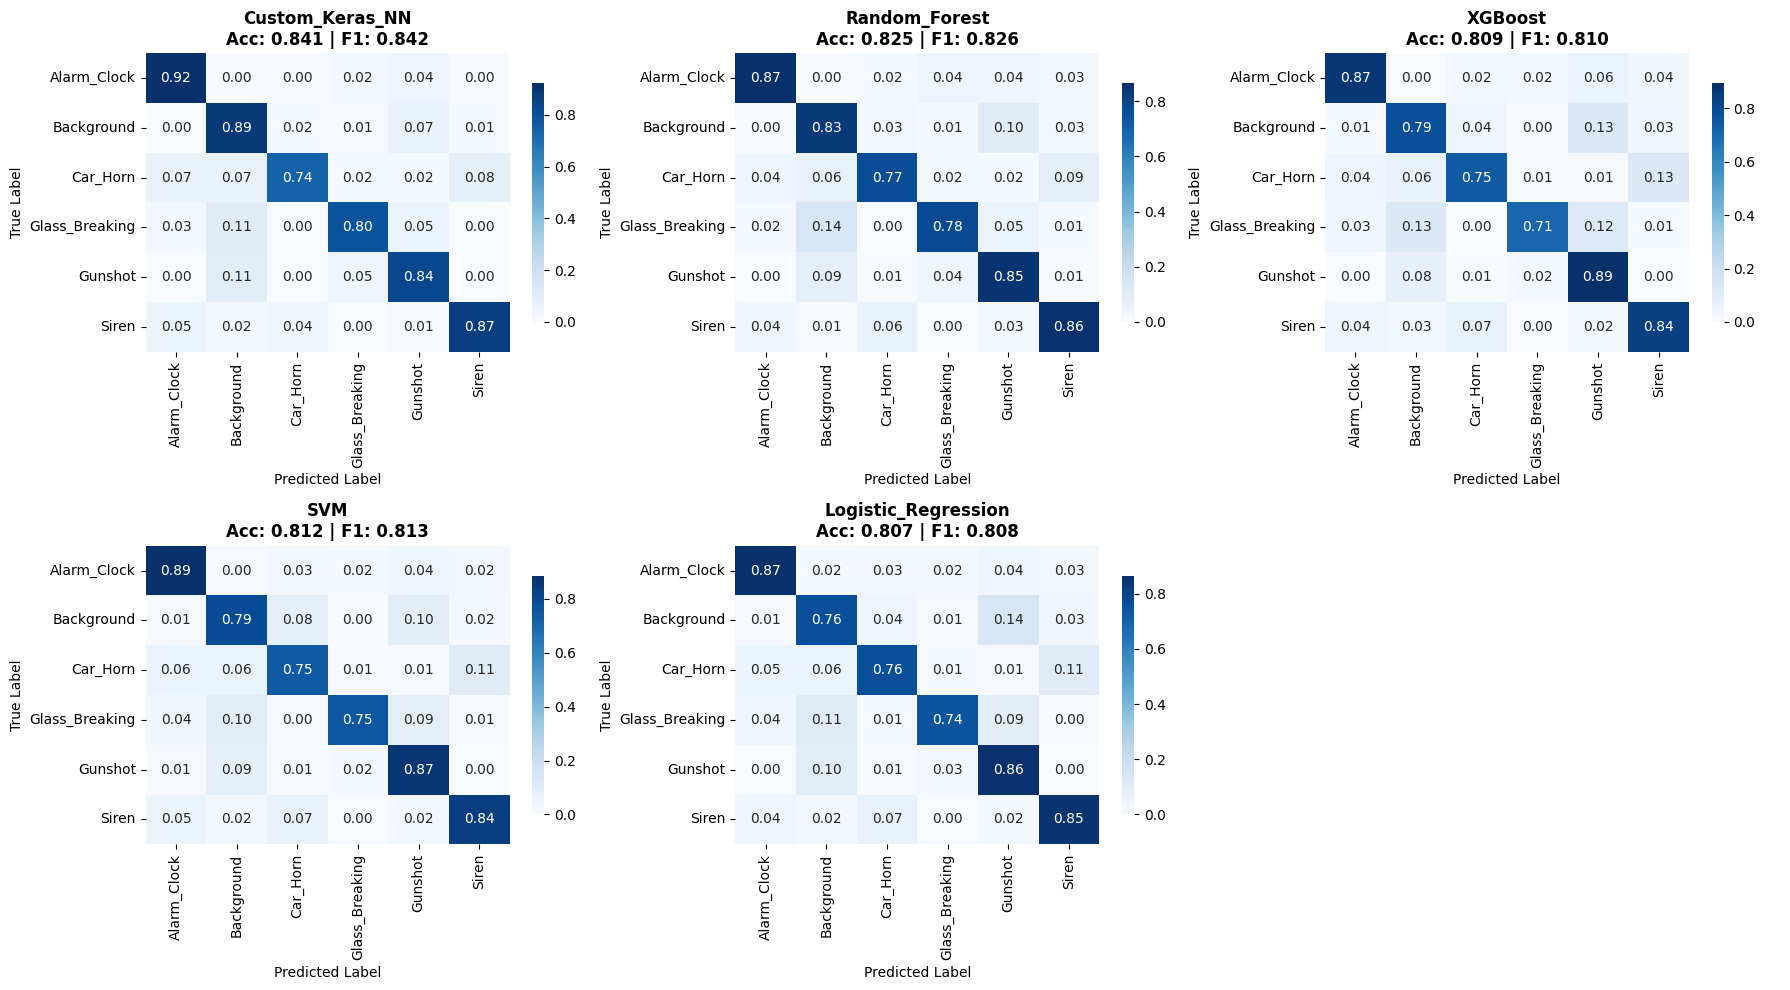

In [22]:
# ==================== CONFUSION MATRICES ====================
print("\nGENERATING CONFUSION MATRICES")
n_models = len(all_predictions)
if n_models > 0:
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for idx, (model_name, y_pred) in enumerate(all_predictions.items()):
        cm = confusion_matrix(y_test_encoded, y_pred) # Use encoded vs encoded
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=classes, yticklabels=classes,
                    ax=axes[idx], cbar_kws={'shrink': 0.8})
        
        acc = results_df[results_df['Model'] == model_name]['Accuracy'].values[0]
        f1 = results_df[results_df['Model'] == model_name]['F1_Macro'].values[0]
        
        axes[idx].set_title(f'{model_name}\nAcc: {acc:.3f} | F1: {f1:.3f}', fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    # Hide unused subplots
    for j in range(len(all_predictions), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    cm_path = os.path.join(RESULTS_DIR, 'final_test_confusion_matrices.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrices saved: {cm_path}")
    plt.show()


GENERATING ROC CURVES
ROC curves saved: ../results/results_approach1\final_test_roc_curves.png


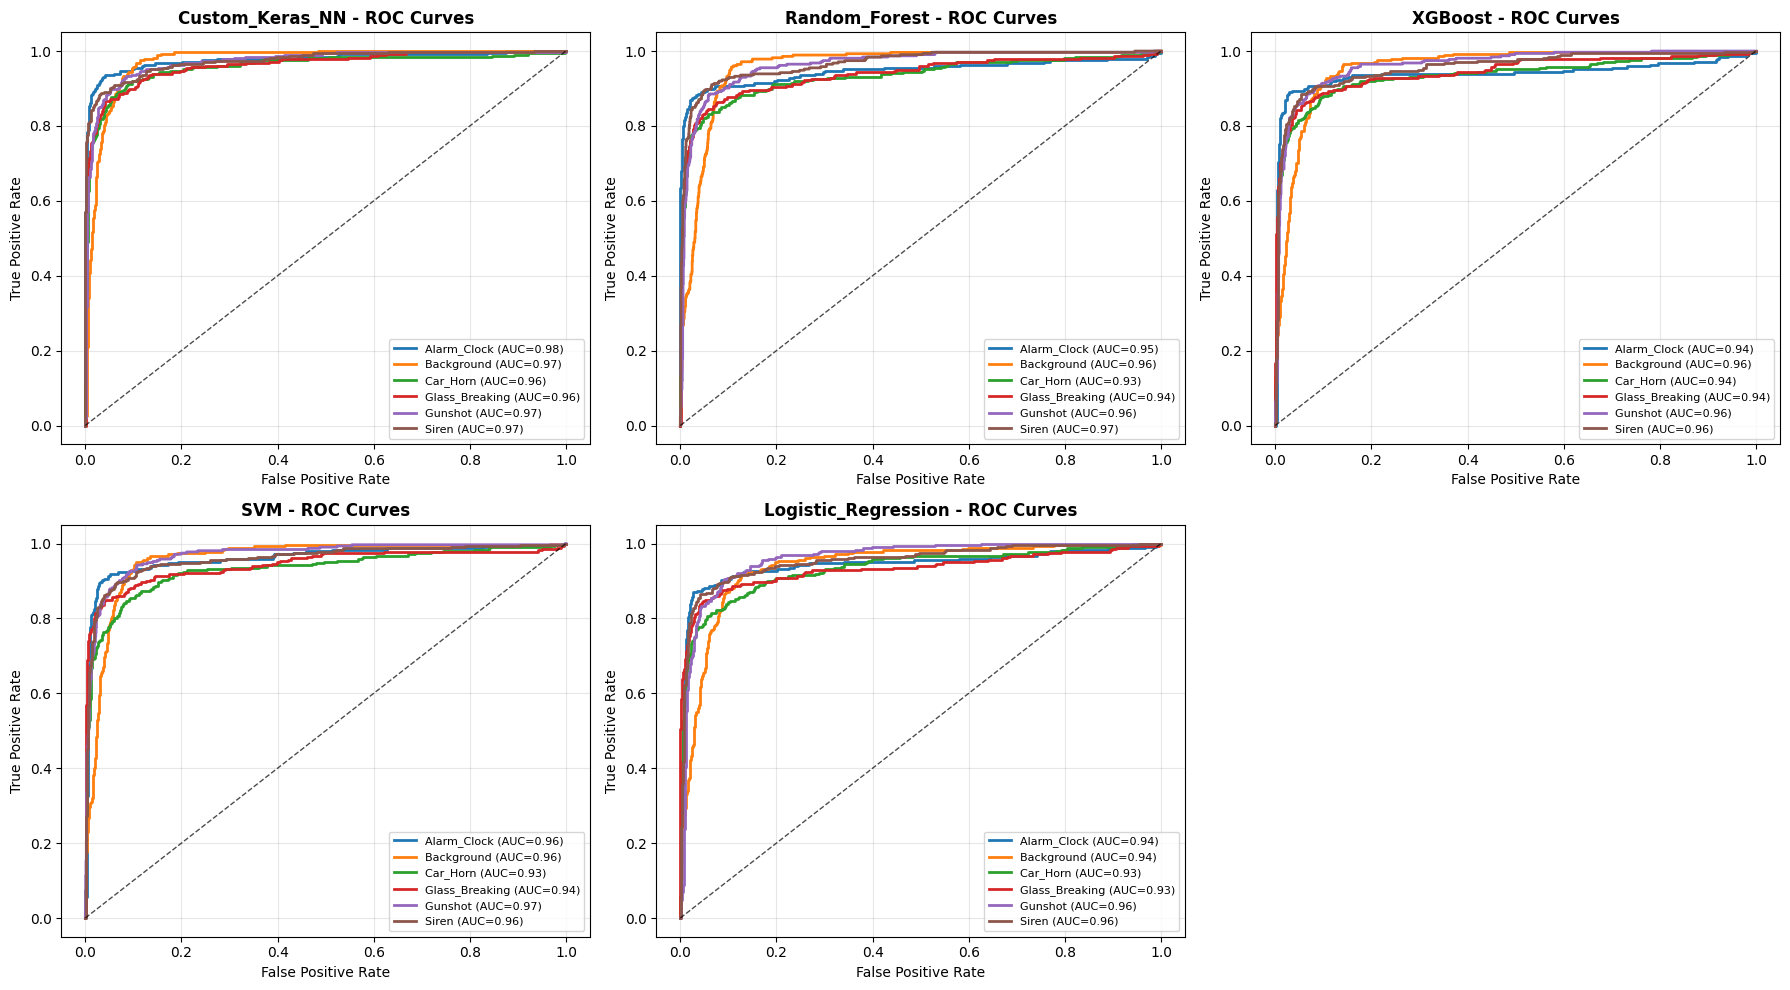

In [23]:
# ==================== ROC CURVES ====================
print("\nGENERATING ROC CURVES")
if n_models > 0:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for idx, (model_name, probs) in enumerate(all_probabilities.items()):
        for i, class_name in enumerate(classes):
            y_binary = (y_test_encoded == i).astype(int)
            fpr, tpr, _ = roc_curve(y_binary, probs[:, i])
            roc_auc = auc(fpr, tpr)
            axes[idx].plot(fpr, tpr, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')
        
        axes[idx].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.7)
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'{model_name} - ROC Curves', fontweight='bold')
        axes[idx].legend(fontsize=8, loc='lower right')
        axes[idx].grid(alpha=0.3)

    # Hide unused subplots
    for j in range(len(all_probabilities), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    roc_path = os.path.join(RESULTS_DIR, 'final_test_roc_curves.png')
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    print(f"ROC curves saved: {roc_path}")
    plt.show()


GENERATING PER-CLASS F1 SCORES
Per-class F1 chart saved: ../results/results_approach1\final_per_class_f1.png


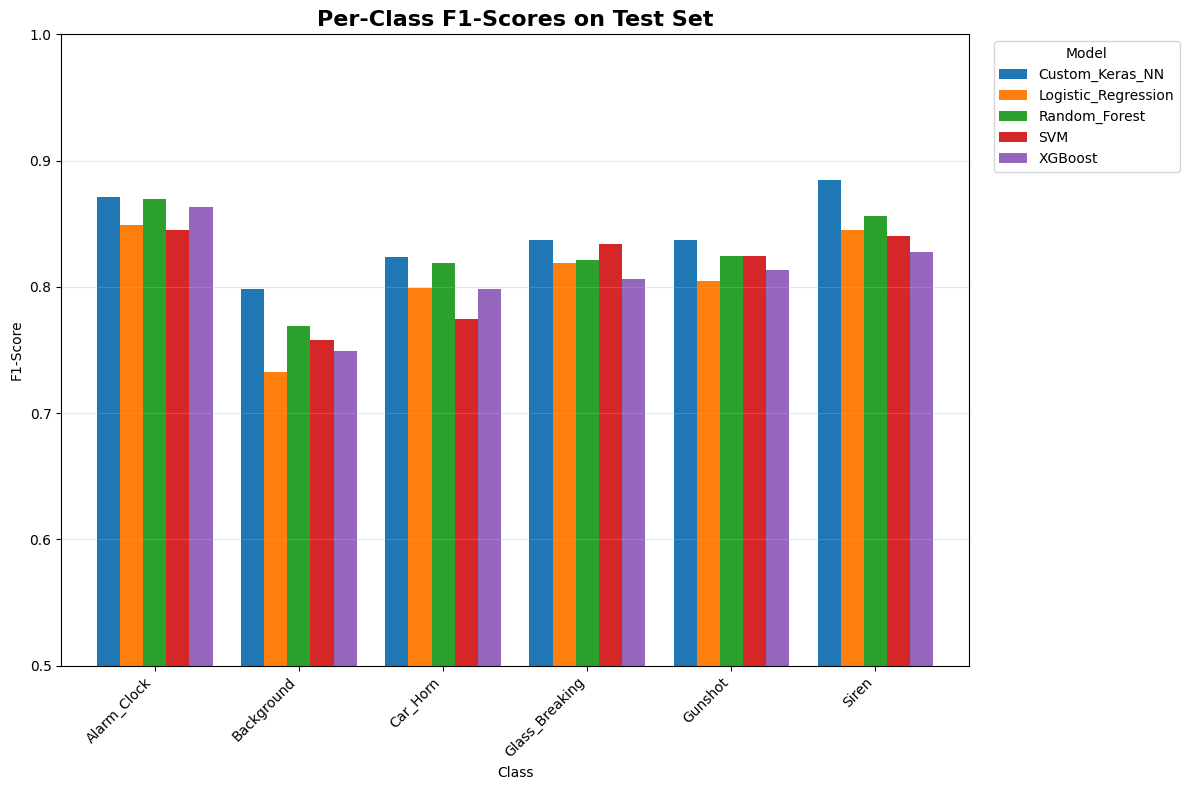

Per-class metrics saved: ../results/results_approach1\final_per_class_metrics.csv


In [24]:
# ==================== PER-CLASS F1 SCORES ====================
print("\nGENERATING PER-CLASS F1 SCORES")

per_class_data = []
# Ensure we have predictions before plotting
if len(all_predictions) > 0:
    for model_name, y_pred in all_predictions.items():
        # Use y_test_encoded and target_names for report
        report = classification_report(y_test_encoded, y_pred, target_names=classes, output_dict=True)
        for cls in classes:
            per_class_data.append({
                'Model': model_name,
                'Class': cls,
                'F1': report[cls]['f1-score'],
                'Precision': report[cls]['precision'],
                'Recall': report[cls]['recall'],
                'Support': int(report[cls]['support'])
            })

    per_class_df = pd.DataFrame(per_class_data)
    pivot_f1 = per_class_df.pivot(index='Class', columns='Model', values='F1')

    plt.figure(figsize=(12, 8))
    pivot_f1.plot(kind='bar', ax=plt.gca(), width=0.8)
    plt.title('Per-Class F1-Scores on Test Set', fontsize=16, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xlabel('Class')
    plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.5, 1.0) # Adjusted ylim to see better spread
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    per_class_path = os.path.join(RESULTS_DIR, 'final_per_class_f1.png')
    plt.savefig(per_class_path, dpi=300, bbox_inches='tight')
    print(f"Per-class F1 chart saved: {per_class_path}")
    plt.show()

    # Save per-class details
    per_class_csv = os.path.join(RESULTS_DIR, 'final_per_class_metrics.csv')
    per_class_df.to_csv(per_class_csv, index=False)
    print(f"Per-class metrics saved: {per_class_csv}")


GENERATING PERFORMANCE vs SIZE & LATENCY
Tradeoff analysis saved: ../results/results_approach1\final_tradeoff_analysis.png


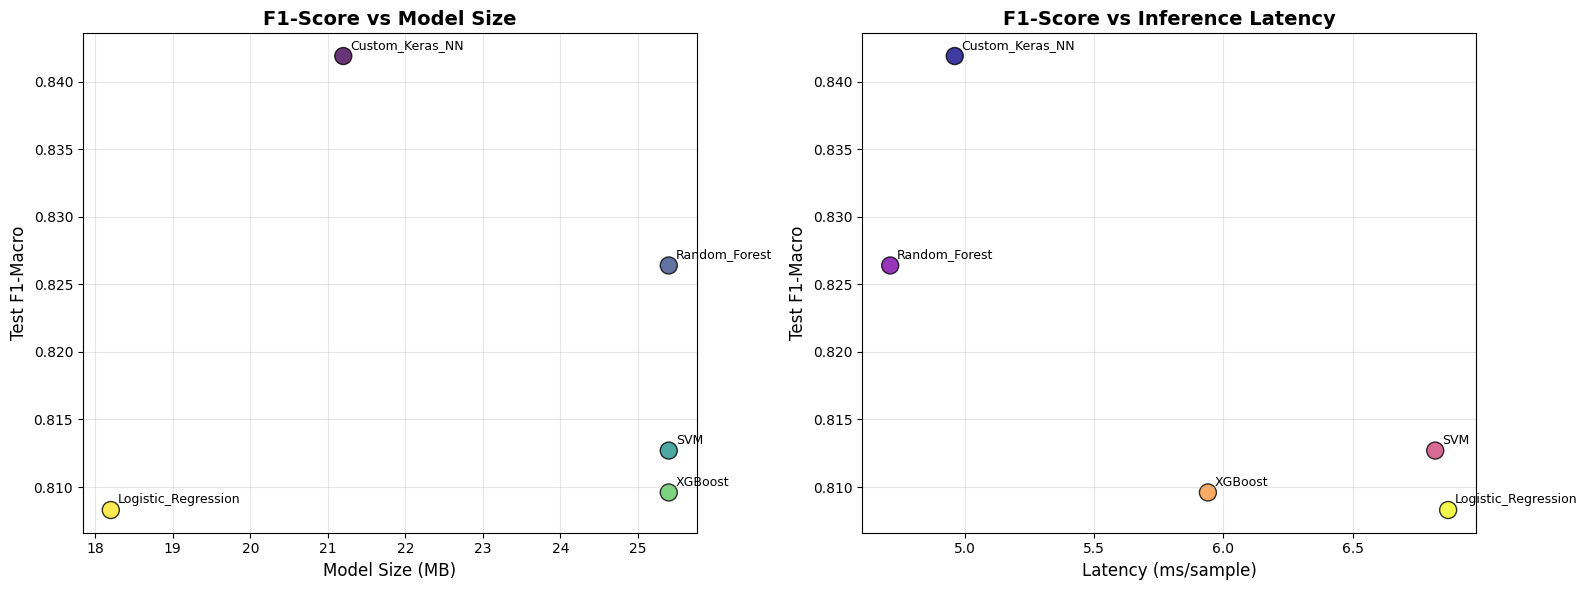

In [25]:
# ==================== PERFORMANCE TRADEOFFS ====================
print("\nGENERATING PERFORMANCE vs SIZE & LATENCY")

if len(results_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # F1 vs Size
    sizes = results_df['Size_MB']
    f1s = results_df['F1_Macro']
    models = results_df['Model']

    ax1.scatter(sizes, f1s, s=150, c=range(len(models)), cmap='viridis', alpha=0.8, edgecolors='black')
    for i in range(len(models)):
        ax1.annotate(models.iloc[i], (sizes.iloc[i], f1s.iloc[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    ax1.set_xlabel('Model Size (MB)', fontsize=12)
    ax1.set_ylabel('Test F1-Macro', fontsize=12)
    ax1.set_title('F1-Score vs Model Size', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    # F1 vs Latency
    latency = results_df['Latency_ms_per_sample']
    ax2.scatter(latency, f1s, s=150, c=range(len(models)), cmap='plasma', alpha=0.8, edgecolors='black')
    for i in range(len(models)):
        ax2.annotate(models.iloc[i], (latency.iloc[i], f1s.iloc[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    ax2.set_xlabel('Latency (ms/sample)', fontsize=12)
    ax2.set_ylabel('Test F1-Macro', fontsize=12)
    ax2.set_title('F1-Score vs Inference Latency', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    tradeoff_path = os.path.join(RESULTS_DIR, 'final_tradeoff_analysis.png')
    plt.savefig(tradeoff_path, dpi=300, bbox_inches='tight')
    print(f"Tradeoff analysis saved: {tradeoff_path}")
    plt.show()

In [26]:
# ==================== FINAL REPORT ====================
if len(results_df) > 0:
    best_model = results_df.iloc[0]
    print(f"\nBEST MODEL: {best_model['Model']}")
    print(f"  Test F1-Macro:  {best_model['F1_Macro']:.4f}")
    print(f"  Test Accuracy:  {best_model['Accuracy']:.4f}")
    print(f"  Precision:      {best_model['Precision']:.4f}")
    print(f"  Recall:         {best_model['Recall']:.4f}")
    print(f"  Latency:        {best_model['Latency_ms_per_sample']:.2f} ms/sample")
    print(f"  Model Size:     {best_model['Size_MB']}")


BEST MODEL: Custom_Keras_NN
  Test F1-Macro:  0.8419
  Test Accuracy:  0.8414
  Precision:      0.8474
  Recall:         0.8441
  Latency:        4.96 ms/sample
  Model Size:     21.2
